# cleanup data and store for latter processing

To do:

- add wind information:
    - [ ] wind station (got it but need to be processed)
- go get tide information (currents, sea level):
    - [ ] SMILE ADCP data (waiting
- satellite data: S2, SST
    - [ ] ask
    - [ ] process
    

In [1]:
import os

%matplotlib inline
import matplotlib.pyplot as plt
import cmocean.cm as cm

import numpy as np
import pandas as pd
import xarray as xr

# 
import pynsitu as pin
from pynsitu.maps import crs
import taos.sensors as se

/Users/aponte/.miniconda3/envs/pynsitu/lib/python3.10/site-packages/pyTMD/tools.py:55: UserWarning: ipyleaflet not available
  warnings.warn("ipyleaflet not available")
/Users/aponte/.miniconda3/envs/pynsitu/lib/python3.10/site-packages/pyTMD/tools.py:56: UserWarning: Some functions will throw an exception if called
  warnings.warn("Some functions will throw an exception if called")


In [2]:
## taos
root_dir = "/Users/aponte/Current_Projects/taos/campagnes/taos0/"

# taos0-drifters0
campaign="taos0_drifters0"
yaml = f"drifters0/{campaign}.yaml"

# taos0-drifters1
#campaign="taos0_drifters1"
#yaml = f"drifters1/{campaign}.yaml"

cp = pin.Campaign(os.path.join(root_dir,yaml))

---

## observed and modelled sea level and tidal currents

In [ ]:
import taos.utils as ut
dsh = ut.predict_tides(_ds.date_start, real=False, summed=False)

---

## river discharges

---

## tides, sea level/currents



In [3]:
tgauge_dir = "/Users/aponte/Data/tides/maregraphe"

In [4]:
from glob import glob
tgauge_files = sorted(glob(os.path.join(tgauge_dir, "*.nc")))

ds = xr.open_dataset(tgauge_files[-1])

ds = ds.rename(dict(TIME="time", 
                    LATITUDE="latitude", LONGITUDE="longitude",
                    Source1="sea_level",
                   )
              )

# demean sea level
ds["sea_level"] = ds["sea_level"] - ds["sea_level"].mean("time")

In [5]:
dt = (ds.time.diff("time")/pd.Timedelta("1s"))
print(f" min(dt)= {float(dt.min())} max(dt)= {float(dt.max())} ")

 min(dt)= 60.0 max(dt)= 10106.0 


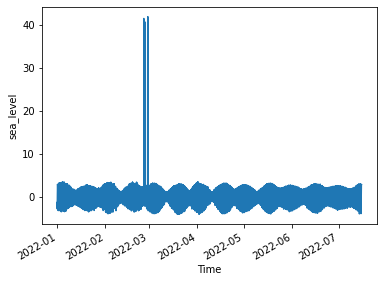

In [6]:
ds.sea_level.plot()

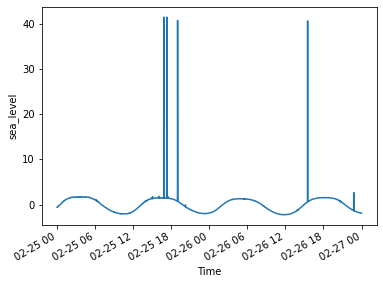

In [57]:
ds.sel(time=slice("2022-02-25","2022-02-26")).sea_level.plot()

In [43]:
#dsr = ds.sel(time=slice(cp.start - pd.Timedelta("10D"), cp.end + pd.Timedelta("10D"))).resample(time="10T").mean()
dsr = ds.sel(time="2022").resample(time="10T").mean()


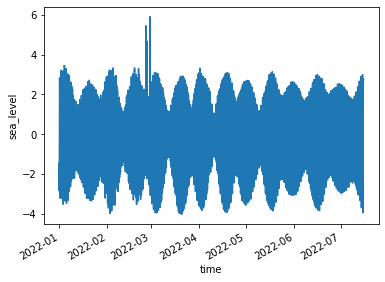

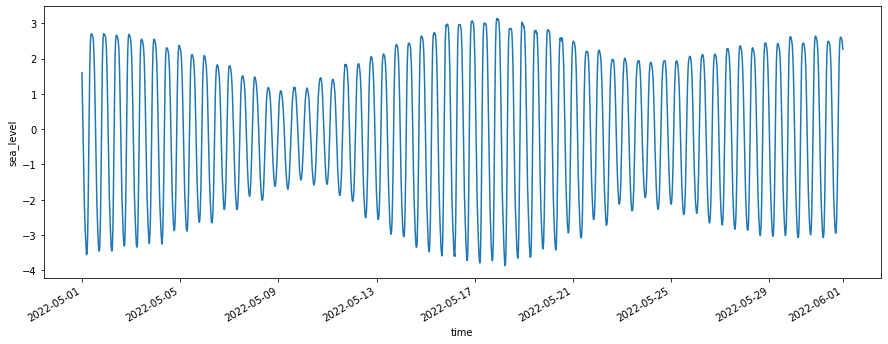

In [44]:
dsr.sea_level.sel(time="2022-05").plot(figsize=(15,5))

/var/folders/pb/vp119fcj1pn3dc3x2dz4dkt80000gn/T/ipykernel_13691/2428150208.py:4: UserWarning: registration of accessor <class '__main__.TimeSeriesAccessor'> under name 'ts' for type <class 'pandas.core.frame.DataFrame'> is overriding a preexisting attribute with the same name.
  class TimeSeriesAccessor:


In [45]:
df = dsr.to_dataframe()
df.ts.time_physical()
df.head()

,latitude,longitude,sea_level,timep
time,,,,
2022-01-01 00:00:00,49.279362,-0.24903,-1.461973,378691200.0
2022-01-01 00:10:00,49.279362,-0.24903,-1.644713,378691800.0
2022-01-01 00:20:00,49.279362,-0.24903,-1.793523,378692400.0
2022-01-01 00:30:00,49.279362,-0.24903,-1.939423,378693000.0
2022-01-01 00:40:00,49.279362,-0.24903,-2.078783,378693600.0


['M2', 'K1', 'S2', 'O1', 'P1', 'N2', 'K2', 'Q1', 'J1', 'L2', 'T2', '2N2', 'MN4', 'M4', 'MS4', 'M6', 'M3', 'R2', 'S1', 'S4', 'MKS2', 'N4', 'M8']


/Users/aponte/.miniconda3/envs/cognac/lib/python3.8/site-packages/matplotlib/text.py:830: ComplexWarning: Casting complex values to real discards the imaginary part
  x = float(self.convert_xunits(self._x))
/Users/aponte/.miniconda3/envs/cognac/lib/python3.8/site-packages/matplotlib/text.py:690: ComplexWarning: Casting complex values to real discards the imaginary part
  posx = float(self.convert_xunits(self._x))


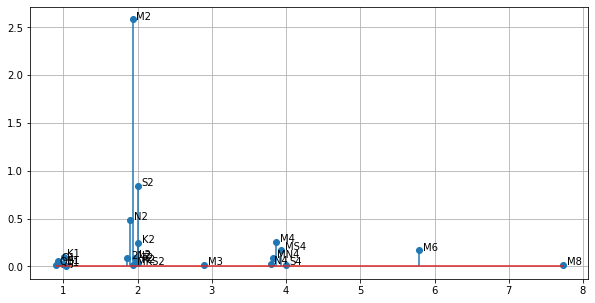

In [46]:
cst = ["O1", "K1", "M2", "S2"]

c = load_equilibrium_constituents()
cst = [c.upper() for c in list(c.sort_values("amplitude", ascending=False)
                               .iloc[:].index
                              )
      ]
cst = [c for c in cst if c not in ["MF", "MM", "SSA", "NU2", "MU2", "EPS2", "MSF", "LAMBDA2", "MSQM", "SA", "MTM"]]
print(cst)

#cst = cst + ["M4", "MS4"]

df.ts.tidal_analysis("sea_level", constituents=cst)

/var/folders/pb/vp119fcj1pn3dc3x2dz4dkt80000gn/T/ipykernel_13691/2428150208.py:220: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  v =  ( f * np.exp(1j*vu) * np.conj(har[:,None]) ).sum(axis=0)


<AxesSubplot:xlabel='time'>

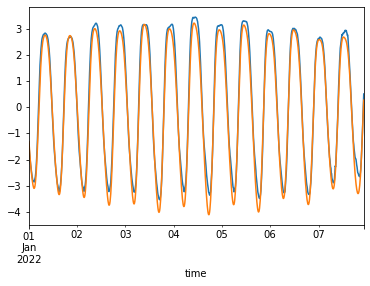

In [47]:
df["sea_level_tide"] = df.ts.tidal_predict("sea_level")

sl = slice(0,1000)
#sl = slice(0,None)

df["sea_level"].iloc[sl].plot()
df["sea_level_tide"].iloc[sl].plot()

In [50]:
# store
dsr.to_netcdf(os.path.join(cp["path_processed"], f'sea_level.nc'), mode="w")

In [ ]:
---

## bouées

In [58]:
b_dir = "/Users/aponte/Current_Projects/taos/campagnes/taos0/drifters1/coriolis"

file = os.path.join(b_dir, "mooring-buoys-time-series-6200310.nc")
ds = xr.open_dataset(file)
ds

<xarray.Dataset>
Dimensions:                          (N_PROF: 28845, N_PARAM: 17, N_LEVELS: 1, N_CALIB: 1, N_HISTORY: 0)
Dimensions without coordinates: N_PROF, N_PARAM, N_LEVELS, N_CALIB, N_HISTORY
Data variables: (12/148)
    DATA_TYPE                        object ...
    FORMAT_VERSION                   object ...
    HANDBOOK_VERSION                 object ...
    REFERENCE_DATE_TIME              object ...
    DATE_CREATION                    object ...
    DATE_UPDATE                      object ...
    ...                               ...
    HISTORY_ACTION                   (N_HISTORY, N_PROF) object ...
    HISTORY_PARAMETER                (N_HISTORY, N_PROF) object ...
    HISTORY_START_PRES               (N_HISTORY, N_PROF) float32 ...
    HISTORY_STOP_PRES                (N_HISTORY, N_PROF) float32 ...
    HISTORY_PREVIOUS_VALUE           (N_HISTORY, N_PROF) float32 ...
    HISTORY_QCTEST                   (N_HISTORY, N_PROF) object ...
Attributes:
    title:                
    institution:          
    source:               Coriolis
    history:              2022-07-17T20:00:15Z creation
    references:           http://www.argodatamgt.org/Documentation
    comment:              
    user_manual_version:  3.03
    Conventions:          Argo-3.0 CF-1.6
    featureType:          trajectoryProfile

---

## old stuff

In [25]:
file = "sonde_benji_13.csv"
file_path = os.path.join(root_dir, file)
df = read_sonde_lern(file_path, stype=1)

['Date', 'Time', 'Site', 'Unit ID', 'User ID', 'ï¿½C-21A101173', 'mmHg-20L100404', 'DO %-21A100555', 'DO mg/L-21A100555', 'C-mS/cm-21A101173', 'SAL-PSU-21A101173', 'DEP m-20H100561']


array([<AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>], dtype=object)

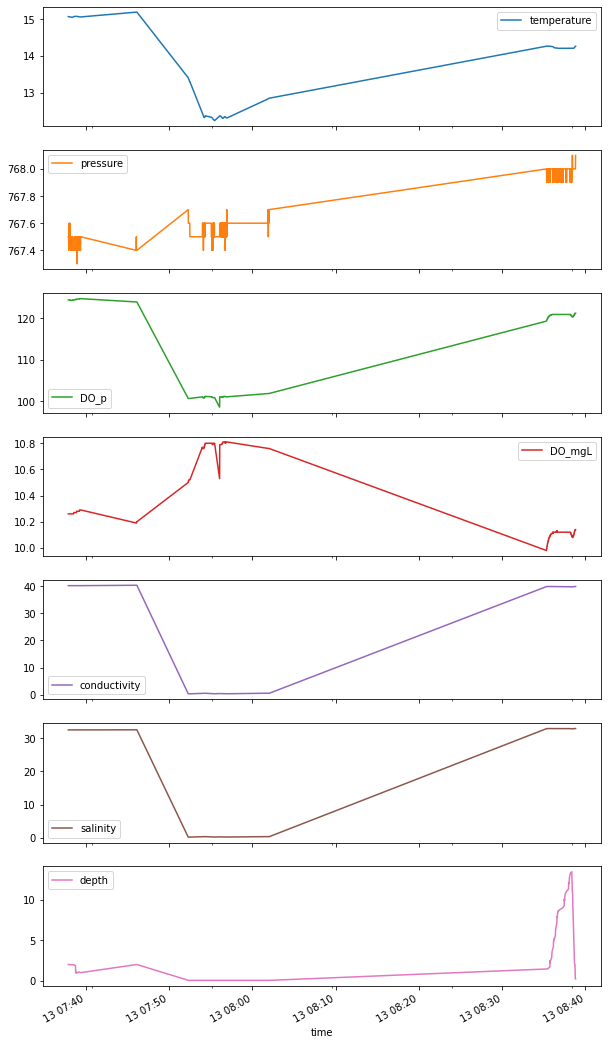

In [26]:
df.plot(subplots=True, figsize=(10,20))